# House Prices - Advanced Regression Techniques
(Preços de casas - Técnicas Avançadas de Regressão)

<img src="https://storage.googleapis.com/kaggle-media/competitions/House%20Prices/kaggle_5407_media_housesbanner.png" width=800>


- Vamos utilizar o [dataset disponível no Kaggle](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview)
    - É um dataset de **competição**
    - Temos uma base com a **descrição de cada uma das colunas (data_description.txt)**
- **Etapas do Projeto:**
    - O projeto será realizado aplicando submissões no kaggle a medida que o tratamento dos dados forem tomando forma, isso possibilita verificar o desempenho dos modelos preditivos a modificações específicas neste tratamento.

**Utilizando os modelos na base tratada**

In [58]:
import pandas as pd

In [59]:
# Importando os datasets
base_train = pd.read_csv('train_1.csv')
base_test = pd.read_csv('test_1.csv')

## Submissões dos checkpoints
- Escolher modelos mais indicados para as bases dado o observado no tratamento
- Realizar seleção de features
- Otimizar hiperparâmetros dos modelos
- Submeter no Kaggle
- Comparar desempenhos de tratamentos e modelos

In [60]:
# Selecionar colunas numéricas
col_n = base_train.columns[base_train.dtypes != 'object']
col_n

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice',
       'GarageArea/Car', 'AreaTotalBsmt'],
      dtype='object')

In [61]:
# Atribuindo essas colunas a nossa base
base_train = base_train.loc[:,col_n]

In [62]:
base_test = base_test.loc[:,col_n.drop('SalePrice')]

### Métrica de avaliação (RMSLE)
- Essa função será utilizada para seleção de features e como scoring do GridSearchCV
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRxDZcRHy4lOtYjOjcxhn72vPMjBGjRnPxkKA&s" width=800>

In [63]:
# Definir função que calcula essa métrica
import numpy as np
from sklearn.metrics import make_scorer

# Função para calcular o RMSLE
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2)))

## Criando modelos

- **Vamos separar em treino e teste**
    - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [64]:
# Selecionando X e y
X = base_train.drop('SalePrice',axis=1)
y = base_train.SalePrice

In [65]:
# Importando o train_test_split
from sklearn.model_selection import train_test_split

In [66]:
# Separando essa base em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Seleção de algorítmos:
- Observamos que nossa base possui as seguintes características:
    - Poucos dados (linhas)
    - Muitas features
    - Aproximadamente a mesma quantidade de variáveis numéricas e categóricas
    - Correlação não linear features vs target
    - Distribuição um tanto assimétrica da target
### Selecionar 3 modelos para testar 
    - Gradient Booster (indicado na própria competição)
    - XGBoost Regressor (Variação do Gradiente boosting)
    - Lasso (Apesar de ser um modelo linear lida bem com alta dimensionalidade e poucos dados)

## Gradient Boosting

#### Determinar a importancia das features de acordo com o modelo 

In [67]:
# Importar o algorítmo
from sklearn.ensemble import GradientBoostingRegressor
# Setar o random state para todos os modelos, isso possibilita tirar a aleatoriedade e sempre obter os mesmos valores
random_state = 0
# Chamar o modelo
GB = GradientBoostingRegressor(random_state=0)
# Fit do modelo
GB.fit(X_train, y_train)
# Extrair importâncias das features de acordo com o modelo
importances = GB.feature_importances_
# Ordenar de forma decrescente as features com melhor importancia
feature_importance_GB = pd.Series(abs(importances), index=X_train.columns).sort_values(ascending=False)
print(feature_importance_GB)

OverallQual       0.515628
GrLivArea         0.135157
AreaTotalBsmt     0.074808
GarageArea/Car    0.057418
BsmtFinSF1        0.054327
YearBuilt         0.028047
2ndFlrSF          0.021973
LotArea           0.020097
YearRemodAdd      0.017973
Fireplaces        0.012270
ScreenPorch       0.011210
GarageYrBlt       0.010650
WoodDeckSF        0.008044
OverallCond       0.006230
OpenPorchSF       0.003539
MasVnrArea        0.003526
TotRmsAbvGrd      0.003140
MSSubClass        0.003052
BsmtUnfSF         0.002460
BsmtFinSF2        0.002312
LotFrontage       0.002272
KitchenAbvGr      0.001340
BsmtFullBath      0.001132
3SsnPorch         0.000915
Id                0.000861
BedroomAbvGr      0.000577
MoSold            0.000447
YrSold            0.000357
EnclosedPorch     0.000140
BsmtHalfBath      0.000070
HalfBath          0.000019
FullBath          0.000007
MiscVal           0.000000
LowQualFinSF      0.000000
dtype: float64


### Utilizar o modelo em ordem crescente de features com a maior importancia e observar melhor desempenho

In [68]:
from sklearn.metrics import mean_squared_error

performance_GB = []

# Observar quantidade ideal de dimenssão neste modelo (maldição da dimensionalidade)

for i in range(1, len(X_train.columns)+1):  
    X_train_selected = X_train.loc[:,feature_importance_GB.index[:i]]
    X_test_selected = X_test.loc[:,feature_importance_GB.index[:i]]
    
    GB = GradientBoostingRegressor(random_state=0)
    GB.fit(X_train_selected, y_train)
    
    y_pred = GB.predict(X_test_selected)
    
    performance_GB.append(rmsle(y_test, y_pred))
    
performance_GB

[0.22968195305513636,
 0.2113581682522095,
 0.18940974603934943,
 0.17843366592625132,
 0.17087527885581175,
 0.16298788639825235,
 0.15825570284521528,
 0.15741215737885017,
 0.15285034824203078,
 0.15104874818414896,
 0.15485950322236866,
 0.15353502079784573,
 0.1534516254818357,
 0.13997172612002906,
 0.14160963842961324,
 0.1420393173413539,
 0.14232090461235622,
 0.13961546501340022,
 0.14080660434867504,
 0.1402026787934328,
 0.14126084620769955,
 0.14111965872768184,
 0.1440716155000456,
 0.14358992328050277,
 0.14265512130848407,
 0.14393289318582334,
 0.1442096841216017,
 0.1443802892429437,
 0.14296003596375342,
 0.14441316129797843,
 0.1428154884805101,
 0.14383882095711398,
 0.14413044390659538,
 0.1435236196794134]

### RMSLE em função da quantidade de features

<Figure size 2400x1600 with 0 Axes>

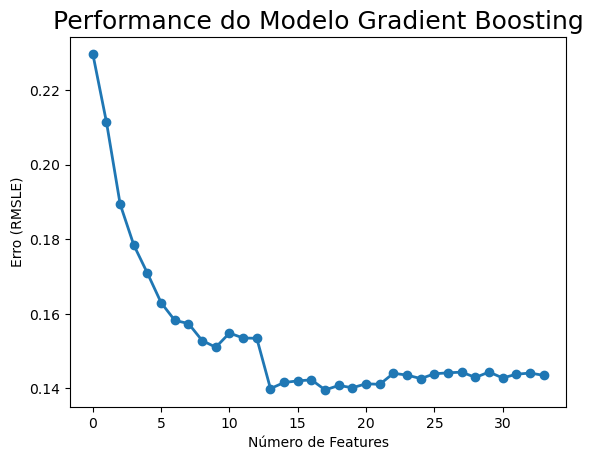

In [69]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(24, 16))
# plot
fig, ax = plt.subplots()

ax.plot(range(len(performance_GB)), performance_GB, linewidth=2.0, marker='o')

ax.set_title('Performance do Modelo Gradient Boosting', fontsize=18)
ax.set_xlabel('Número de Features', fontsize=10)
ax.set_ylabel('Erro (RMSLE)', fontsize=10)

plt.show()

In [70]:
# Valore ideal de features
performance_GB.index(min(performance_GB))

17

In [71]:
# Treinando com a quantidade ideal de features
GB = GradientBoostingRegressor(random_state=0)
GB.fit(X_train.loc[:,feature_importance_GB.index[:performance_GB.index(min(performance_GB))+1]], y_train)

y_pred_gb = GB.predict(X_test.loc[:,feature_importance_GB.index[:performance_GB.index(min(performance_GB))+1]])

RMSLE_GB = rmsle(y_test, y_pred)
RMSLE_GB

0.1435236196794134

## XGBoost

In [72]:
import xgboost as xgb
#Criando modelo e fazendo o fit
XG = xgb.XGBRegressor(random_state=random_state)
XG.fit(X_train, y_train)
# Determinando as importâncias individuais de cada feature
importances_XG = XG.feature_importances_
# Armazenando as importancias em ordem decrescente
feature_importance_XG = pd.Series(abs(importances_XG), index=X_train.columns).sort_values(ascending=False)
print(feature_importance_XG)

OverallQual       0.675852
GrLivArea         0.054018
KitchenAbvGr      0.041441
AreaTotalBsmt     0.029876
Fireplaces        0.023544
FullBath          0.020089
ScreenPorch       0.019795
BsmtFinSF1        0.015830
GarageArea/Car    0.013337
BsmtFullBath      0.010293
LotFrontage       0.010200
TotRmsAbvGrd      0.009793
YearRemodAdd      0.009260
GarageYrBlt       0.007890
YearBuilt         0.006851
BedroomAbvGr      0.006191
OverallCond       0.005908
LotArea           0.005845
2ndFlrSF          0.005774
BsmtFinSF2        0.003468
WoodDeckSF        0.003227
3SsnPorch         0.002799
EnclosedPorch     0.002626
OpenPorchSF       0.002521
MoSold            0.002202
YrSold            0.002197
MasVnrArea        0.002172
MSSubClass        0.002049
HalfBath          0.001625
BsmtUnfSF         0.001485
Id                0.000869
BsmtHalfBath      0.000669
MiscVal           0.000230
LowQualFinSF      0.000073
dtype: float32


### Utilizar o modelo em ordem crescente de features com a maior importancia e observar melhor desempenho

In [73]:
performance_XG = []

# Observar quantidade ideal de dimenssão neste modelo (maldição da dimensionalidade)

for i in range(1, len(X_train.columns)+1):  
    X_train_selected = X_train.loc[:,feature_importance_XG.index[:i]]
    X_test_selected = X_test.loc[:,feature_importance_XG.index[:i]]
    
    XG = xgb.XGBRegressor(random_state=random_state)
    XG.fit(X_train_selected, y_train)
    
    y_pred = XG.predict(X_test_selected)
    
    performance_XG.append(rmsle(y_test, y_pred))
    
performance_XG

[0.2296800561534658,
 0.2181568306590205,
 0.2166417617578659,
 0.20396838341692594,
 0.1941011943177252,
 0.19088963136382636,
 0.18584304096707313,
 0.1803220678346442,
 0.1718397315159027,
 0.17225258439740285,
 0.1726282072275151,
 0.17445680405724426,
 0.17107239486506362,
 0.16592226995353165,
 0.16663974678506155,
 0.1724222157883361,
 0.15370149580208842,
 0.1603467233539934,
 0.15065467335486735,
 0.1532341166768413,
 0.15359288149517822,
 0.1560255288525951,
 0.15465971209012797,
 0.15635117073346114,
 0.152783786785591,
 0.1479719984815526,
 0.1513441151568479,
 0.15201629445162596,
 0.15339211187502397,
 0.15128901087665544,
 0.15237605252965766,
 0.15306776279785603,
 0.1543863063481356,
 0.1545771388039607]

### RMSLE em função da quantidade de features

<Figure size 2400x1600 with 0 Axes>

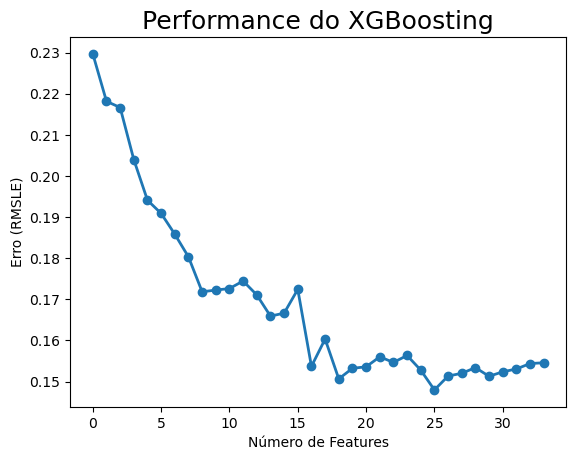

In [74]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(24, 16))
# plot
fig, ax = plt.subplots()

ax.plot(range(len(performance_XG)), performance_XG, linewidth=2.0, marker='o')

ax.set_title('Performance do XGBoosting', fontsize=18)
ax.set_xlabel('Número de Features', fontsize=10)
ax.set_ylabel('Erro (RMSLE)', fontsize=10)

plt.show()

In [75]:
# Valore ideal de features
performance_XG.index(min(performance_XG))

25

In [76]:
# Treinando com a quantidade ideal de features
XG = xgb.XGBRegressor(random_state=random_state)
XG.fit(X_train.loc[:,feature_importance_XG.index[:performance_XG.index(min(performance_XG))+1]], y_train)

y_pred_xg = XG.predict(X_test.loc[:,feature_importance_XG.index[:performance_XG.index(min(performance_XG))+1]])

RMSLE_XG = rmsle(y_test, y_pred)
RMSLE_XG

0.1545771388039607

## Lasso

### Aqui é preciso normalizar as features para poder determinar suas importancias, devem estar na mesma escala
#### Utilizar o MinMaxEscaler para poder definir uma escala padrão

In [77]:
from sklearn.preprocessing import MinMaxScaler

# Criar o objeto scaler
scaler = MinMaxScaler(feature_range=(-1,1))

# Ajustar o scaler com os dados de treino
scaler.fit(base_train.drop('SalePrice', axis=1))

# Transformar os dados de treino
base_train_norm = base_train.copy()
base_train_norm[base_train.drop('SalePrice', axis=1).columns] = scaler.transform(base_train.drop('SalePrice', axis=1))

# Transformar os dados de teste
base_test_norm = base_test.copy()
base_test_norm[base_test.columns] = scaler.transform(base_test)

In [78]:
base_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SalePrice,GarageArea/Car,AreaTotalBsmt
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,69.863699,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,...,46.660274,21.954110,3.409589,15.060959,43.489041,6.321918,2007.815753,180921.195890,976.719178,2220.056164
std,421.610009,42.300571,22.027677,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,...,66.256028,61.119149,29.317331,55.757415,496.123024,2.703626,1.328095,79442.502883,709.723243,787.333406
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000,0.000000,334.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000,336.000000,1696.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,25.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000,948.000000,2064.000000
75%,1095.250000,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,...,68.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000,1152.000000,2661.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,547.000000,552.000000,508.000000,480.000000,15500.000000,12.000000,2010.000000,755000.000000,5424.000000,10802.000000


In [79]:
base_train_norm.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SalePrice,GarageArea/Car,AreaTotalBsmt
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.000000,-0.565915,-0.665317,-0.913839,0.133181,0.143836,0.438664,0.162192,-0.871104,-0.842792,...,-0.829396,-0.920456,-0.986576,-0.937246,-0.994389,-0.032379,-0.092123,180921.195890,-0.639853,-0.639653
std,0.577944,0.497654,0.150875,0.093307,0.307333,0.278200,0.437723,0.688180,0.225914,0.161622,...,0.242252,0.221446,0.115423,0.232323,0.064016,0.491568,0.664048,79442.502883,0.261697,0.150427
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,34900.000000,-1.000000,-1.000000
25%,-0.500000,-1.000000,-0.732877,-0.941541,-0.111111,0.000000,0.188406,-0.433333,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.272727,-0.500000,129975.000000,-0.876106,-0.739778
50%,0.000000,-0.647059,-0.671233,-0.923546,0.111111,0.000000,0.463768,0.466667,-1.000000,-0.864103,...,-0.908592,-1.000000,-1.000000,-1.000000,-1.000000,-0.090909,0.000000,163000.000000,-0.650442,-0.669469
75%,0.500000,-0.411765,-0.602740,-0.903700,0.333333,0.250000,0.855072,0.800000,-0.794687,-0.747608,...,-0.751371,-1.000000,-1.000000,-1.000000,-1.000000,0.272727,0.500000,214000.000000,-0.575221,-0.555407
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,755000.000000,1.000000,1.000000


In [80]:
# Separar base normalizada em teste e treino
X_norm = base_train_norm.drop('SalePrice',axis=1)
X_train_norm , X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y, test_size=0.33, random_state=42)

In [81]:
from sklearn.linear_model import Lasso

# Treinar o modelo Lasso
L = Lasso(alpha=0.1, random_state=random_state,max_iter=10000)
L.fit(X_train_norm, y_train_norm)

# Obter os coeficientes do modelo
feature_importance_L = pd.Series(L.coef_, index=X_norm.columns)
feature_importance_L = feature_importance_L.sort_values(ascending=False)
# Exibir a importância das features
print("Importância das Features:")
print(feature_importance_L)

Importância das Features:
GrLivArea         84929.020458
OverallQual       81183.606712
GarageArea/Car    58601.834213
LotArea           51564.817488
TotRmsAbvGrd      43383.634394
ScreenPorch       20443.510306
YearBuilt         19966.497148
BsmtFullBath      17865.970361
BsmtFinSF1        17672.346421
MasVnrArea        15760.735204
3SsnPorch         14842.666349
OverallCond       13911.178366
FullBath          10455.632088
WoodDeckSF        10236.380383
Fireplaces         9737.753072
YearRemodAdd       5627.353974
LowQualFinSF       3028.225666
HalfBath           2637.544214
EnclosedPorch      1668.059156
YrSold              461.192773
MoSold              460.639499
AreaTotalBsmt         0.000000
BsmtFinSF2         -247.941059
BsmtHalfBath       -767.961587
BsmtUnfSF         -2036.820301
Id                -2657.290493
2ndFlrSF          -4811.473988
GarageYrBlt       -5325.103962
OpenPorchSF       -5775.822622
MSSubClass       -17645.477169
KitchenAbvGr     -19159.031498
MiscVal      

### Utilizar o modelo em ordem crescente de features com a maior importancia e observar melhor desempenho

In [100]:
performance_L = []

# Observar quantidade ideal de dimenssão neste modelo (maldição da dimensionalidade)

for i in range(1, len(X_train_norm.columns)+1):  
    X_train_selected = X_train_norm.loc[:,feature_importance_L.index[:i]]
    X_test_selected = X_test_norm.loc[:,feature_importance_L.index[:i]]
    
    L = Lasso(alpha=0.1, random_state=random_state,max_iter=100000)
    L.fit(X_train_selected, y_train_norm)
    
    y_pred_L = L.predict(X_test_selected)
    
    performance_L.append(rmsle(y_test, y_pred_L))

performance_L

C:\Users\José Vitor\AppData\Local\Temp\ipykernel_7004\280771610.py:7: RuntimeWarning: invalid value encountered in log1p
  return np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2)))
C:\Users\José Vitor\AppData\Local\Temp\ipykernel_7004\280771610.py:7: RuntimeWarning: invalid value encountered in log1p
  return np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2)))
C:\Users\José Vitor\AppData\Local\Temp\ipykernel_7004\280771610.py:7: RuntimeWarning: invalid value encountered in log1p
  return np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2)))
C:\Users\José Vitor\AppData\Local\Temp\ipykernel_7004\280771610.py:7: RuntimeWarning: invalid value encountered in log1p
  return np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2)))


[0.2735080759312324,
 0.23262458199602187,
 0.21914536372932922,
 0.21773267303358962,
 0.2183270823181626,
 0.22124690090293786,
 0.2034360715730782,
 0.20383794868094599,
 0.2043562176985046,
 0.20058032256403277,
 0.20166223189088445,
 0.1832892247591224,
 0.18358069404810784,
 0.1841755043914054,
 0.20159690631246663,
 0.19557741791708302,
 0.1959387097037798,
 0.1952263342639725,
 0.19568206297859966,
 0.1958174890339149,
 0.19548550416467675,
 0.19509273358569962,
 0.1951605679039611,
 0.1950454076936282,
 0.19580439544973052,
 0.19573255038055937,
 0.19573403458651456,
 0.1903868644882559,
 0.19038181785274133,
 0.18179248515008092,
 0.18272177919405075,
 0.18267878278608254,
 0.18460323104135934,
 0.1760678524357901]

### RMSLE em função da quantidade de features

<Figure size 2400x1600 with 0 Axes>

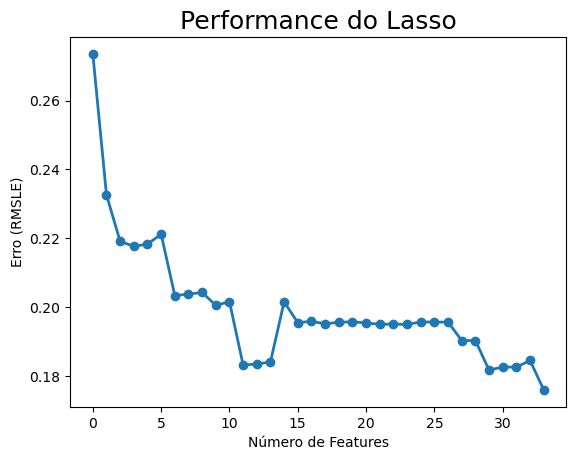

In [101]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(24, 16))
# plot
fig, ax = plt.subplots()

ax.plot(range(len(performance_L)), performance_L, linewidth=2.0, marker='o')

ax.set_title('Performance do Lasso', fontsize=18)
ax.set_xlabel('Número de Features', fontsize=10)
ax.set_ylabel('Erro (RMSLE)', fontsize=10)

plt.show()

In [102]:
# Valore ideal de features
performance_L.index(min(performance_L))

33

In [104]:
# Treinando com a quantidade ideal de features
L = Lasso(alpha=0.1, random_state=random_state,max_iter=100000)
L.fit(X_train_norm.loc[:,feature_importance_L.index[:performance_L.index(min(performance_L))+1]], y_train_norm)

y_pred_l = L.predict(X_test_norm.loc[:,feature_importance_L.index[:performance_L.index(min(performance_L))+1]])

RMSLE_L = rmsle(y_test, y_pred_l)
RMSLE_L

0.1760678524357901

- **Resumo do melhor desempenho de cada modelo:**    

In [105]:
# Importando o erro médio absoluto
print("Melhores RMSLE")
print("Gradiente Boosting: {}".format(RMSLE_GB))
print("XGBoosting: {}".format(RMSLE_XG))
print("Lasso: {}".format(RMSLE_L))

Melhores RMSLE
Gradiente Boosting: 0.1435236196794134
XGBoosting: 0.1545771388039607
Lasso: 0.1760678524357901


- **Podemos plotar visualmente a relação do y_test com as previsões feitas**
    - Predições perfeitas seriam se or pontos estivessem exatamente sobre a reta (y=x)
    - O Gráfico permite observar também a faixa de preços em que o modelo mais acerta e mais erra
    - Preços acima de 500.000 apresentaram dificuldade de predição em todos modelos
    - O motivo disso é que estamos priorizando o RMSLE, e essa métrica penalisa valores muito distantes
    - Podemos ajustar essa característica em função do negócio
- Para isso vamos utilizar o matplotlib
 - https://matplotlib.org/

In [87]:
# Importando o matplotlib
import matplotlib.pyplot as plt

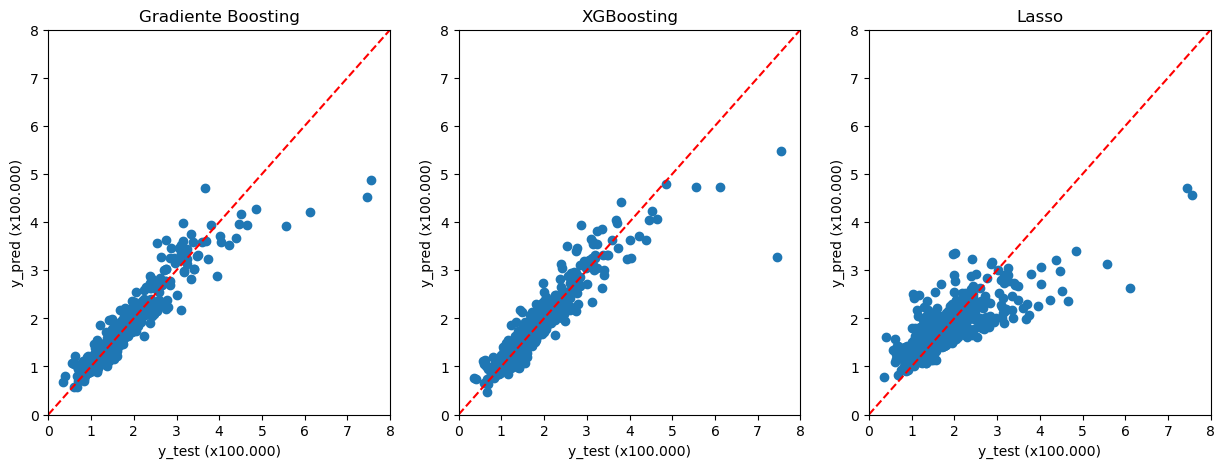

In [88]:
# Criando esse gráfico
fig, ax = plt.subplots(ncols=3,figsize=(15,5))

ax[0].scatter(y_test/100000, y_pred_gb/100000)
ax[0].plot([0,8],[0,8],'--r')
ax[1].scatter(y_test/100000, y_pred_xg/100000)
ax[1].plot([0,8],[0,8],'--r')
ax[2].scatter(y_test/100000, y_pred_l/100000)
ax[2].plot([0,8],[0,8],'--r')

ax[0].set(xlim=(0, 8),ylim=(0, 8))
ax[0].set_xlabel('y_test (x100.000)')
ax[0].set_ylabel('y_pred (x100.000)')
ax[0].set_title('Gradiente Boosting')
ax[1].set(xlim=(0, 8),ylim=(0, 8))
ax[1].set_xlabel('y_test (x100.000)')
ax[1].set_ylabel('y_pred (x100.000)')
ax[1].set_title('XGBoosting')
ax[2].set(xlim=(0, 8),ylim=(0, 8))
ax[2].set_xlabel('y_test (x100.000)')
ax[2].set_ylabel('y_pred (x100.000)')
ax[2].set_title('Lasso')

plt.show()

## Fazendo a previsão para a base de teste da competição
- Considerando o melhor modelo para realizar a predição
- Realizar seleção de features de acordo com o obtido para o modelo em questão

In [89]:
colunas_gb = (X_test.loc[:,feature_importance_GB.index[:performance_GB.index(min(performance_GB))+1]]).columns

In [90]:
# Visualizando a base com todas features
base_test.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,GarageArea/Car,AreaTotalBsmt
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,...,140,0,0,0,120,0,6,2010,730.0,1778.0
1,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,...,393,36,0,0,0,12500,6,2010,312.0,2658.0
2,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,...,212,34,0,0,0,0,3,2010,964.0,1856.0
3,1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,...,360,36,0,0,0,0,6,2010,940.0,1852.0
4,1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,...,0,82,0,0,144,0,1,2010,1012.0,2560.0


In [91]:
# Utilizar as mesmas colunas na base de teste
base_test = base_test[colunas_gb]

In [92]:
# Verificando a base restante
base_test.head()

,OverallQual,GrLivArea,AreaTotalBsmt,GarageArea/Car,BsmtFinSF1,YearBuilt,2ndFlrSF,LotArea,YearRemodAdd,Fireplaces,ScreenPorch,GarageYrBlt,WoodDeckSF,OverallCond,OpenPorchSF,MasVnrArea,TotRmsAbvGrd,MSSubClass
0,5,896,1778.0,730.0,468.0,1961,0,11622,1961,0,120,1961.0,140,6,0,0.0,5,20
1,6,1329,2658.0,312.0,923.0,1958,0,14267,1958,0,0,1958.0,393,6,36,108.0,6,20
2,5,1629,1856.0,964.0,791.0,1997,701,13830,1998,1,0,1997.0,212,5,34,0.0,6,60
3,6,1604,1852.0,940.0,602.0,1998,678,9978,1998,1,0,1998.0,360,6,36,20.0,7,60
4,8,1280,2560.0,1012.0,263.0,1992,0,5005,1992,0,144,1992.0,0,5,82,0.0,5,120


In [93]:
# Verificar valores nulos
base_test.isnull().sum()

OverallQual       0
GrLivArea         0
AreaTotalBsmt     0
GarageArea/Car    0
BsmtFinSF1        0
YearBuilt         0
2ndFlrSF          0
LotArea           0
YearRemodAdd      0
Fireplaces        0
ScreenPorch       0
GarageYrBlt       0
WoodDeckSF        0
OverallCond       0
OpenPorchSF       0
MasVnrArea        0
TotRmsAbvGrd      0
MSSubClass        0
dtype: int64

- **Agora podemos usar nosso modelo e ajustar os dados para usarmos no Kaggle**

In [94]:
# Vamos usar a Regressão Linear para fazer a previsão
y_pred = GB.predict(base_test)

In [95]:
# Podemos adicionar essa coluna de previsão na nossa base
base_test['SalePrice'] = y_pred

In [96]:
test = pd.read_csv("test.csv") 
base_test['Id'] =test.Id

In [97]:
# E extrair somente o Id e o SalePrice
base_kaggle = base_test[['Id','SalePrice']]
base_kaggle.head(3)

,Id,SalePrice
0,1461,128054.664804
1,1462,159884.924756
2,1463,188391.390803


In [106]:
# Podemos então exportar essa base
base_kaggle.to_csv('resultado1.csv',index=False)